In [1]:
from rubin_sim import maf
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline
from rubin_sim.data import get_baseline
import os
import healpy as hp

In [2]:
# new base class. We might consider moving this into BaseMetric, or maybe doing this in the slicer instead.
class BaseTemplateMetric(maf.metrics.BaseMetric):
    """Make a new base class that will filter out observation from before we have templates available
    """
    def __init__(self,
                col=None,
                n_vists_for_template=3.,
                night_template_min=182,
                mjdCol='observationStartMJD',
                nightCol='night',
                filterCol='filter', **kwargs):
        if col is None:
            col = []
        else:
            col = [col]
        col += [mjdCol, nightCol, filterCol]
        super().__init__(col=col, **kwargs)
        self.n_vists_for_template = n_vists_for_template
        self.night_template_min = night_template_min
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        
    def _remove_no_template_visits(self, dataSlice):
        dataSlice.sort(order=self.mjdCol)
        has_template_indx = np.ones(dataSlice.size, dtype=bool)
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0]
            max_indx = np.min([self.n_vists_for_template, np.size(infilt)]).astype(int)
            # The first n visits in a filter can't have a template
            has_template_indx[infilt][0:max_indx] = False
        # Can't have a template before the template construction time
        has_template_indx[np.where(dataSlice[self.nightCol] < self.night_template_min)] = False
        # There is an edge case here were a few spots on the sky might not have 3 visits by 
        # self.night_template_min, and they technically wouldn't get templates generated until
        # the next data release. But I don't want to have multiple data release dates in the kwargs now.
        
        return dataSlice[has_template_indx]
        
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return


In [3]:
# Now here's a metric that uses the new method and only uses visits after templates are made.
class CountWithTemplateMetric(BaseTemplateMetric):
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return np.size(dataSlice)

In [4]:
# Load the baseline simulation
baseline_file = get_baseline()
run_name = os.path.split(baseline_file)[-1].replace('.db', '')

In [5]:
bl = []
summary_stats = [maf.MedianMetric()]
sql = 'filter = "r" and night < 365'
slicer = maf.slicers.HealpixSlicer()
# Our new metric that only counts things after templates have been generated
metric = CountWithTemplateMetric(units='count')
bl.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_stats))

# Let's also run the regular metirc
metric = maf.CountMetric(col='night')
bl.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_stats))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [6]:
mg = maf.MetricBundleGroup(bl, baseline_file, outDir='temp')

Querying table None with constraint filter = "r" and night < 365 for columns ['rotSkyPos', 'night', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 45934 visits
Running:  ['opsim_CountWithTemplate_observationStartMJD_night_filter_r_and_night_lt_365_HEAL', 'opsim_Count_night_r_and_night_lt_365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r" and night < 365" constraint now.


0.0 180.0 -180.0 180.0
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 1038 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 1261 bins, returning 200
  warnings.warn(


Plotting complete.


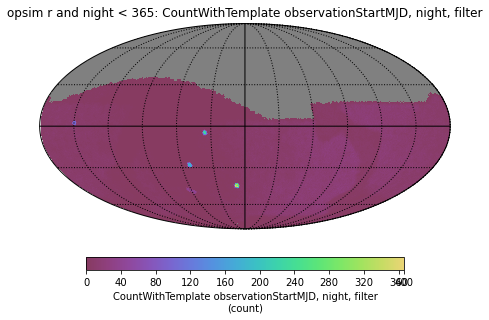

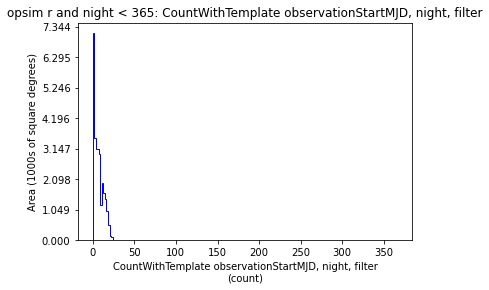

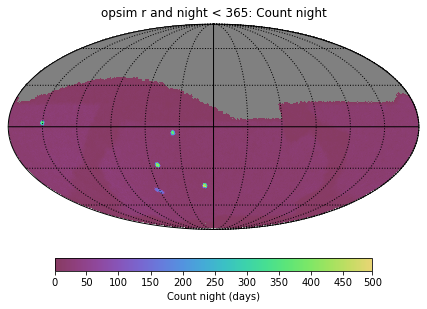

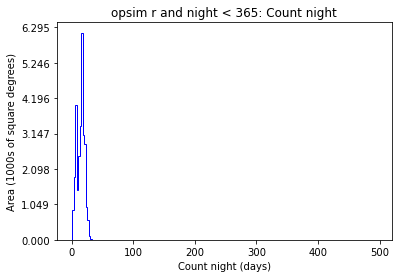

In [7]:
mg.runAll()
mg.plotAll(closefigs=False)

In [8]:
for b in bl:
    print(b.summaryValues)

{'Median': 6.0}
{'Median': 15.0}


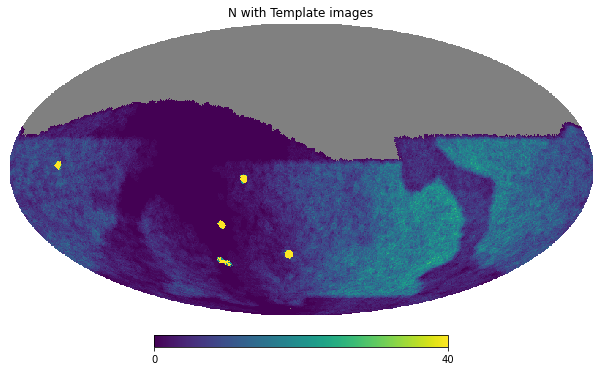

In [9]:
hp.mollview(bl[0].metricValues, max=40, title='N with Template images')

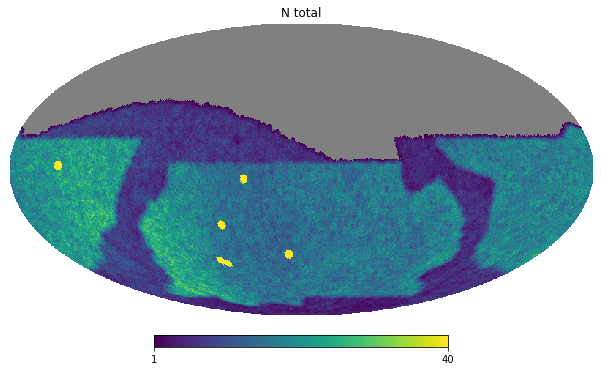

In [10]:
hp.mollview(bl[1].metricValues, max=40, title='N total')

In [11]:
# OK, now let's write a function that takes a bunch of observations in, 
# then cuts out ones that probably don't have template images

# Class that will return all the id's that we think have templates generated
class HasTemplateIndx(BaseTemplateMetric):
    """Return the obIds that probably have templates
    """
    def __init__(self, col='observationId', metricDtype="object", **kwargs):
        super().__init__(col=col, metricDtype=metricDtype, **kwargs)
        self.idCol = col
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return dataSlice[self.idCol]
    

In [12]:
def remove_no_templates(data_in, nside=32, id_col='observationId', **kwargs):
    """Remove visits that probably have no templates
    """
    slicer = maf.slicers.HealpixSlicer(nside=nside, verbose=False)
    metric = HasTemplateIndx(**kwargs)
    sql=None
    bundle = maf.MetricBundle(metric, slicer, sql)
    mbg = maf.MetricBundleGroup([bundle], None, saveEarly=False,
                                verbose=False)
    mbg.runCurrent(None, simData=data_in)
    all_vals = np.concatenate(bundle.metricValues.data[~bundle.metricValues.mask])
    valid_ids = np.unique(all_vals)
    indx = np.in1d(data_in[id_col], valid_ids)
    result = data_in[indx]
    return result

In [13]:
# let's load up some data
data = maf.getSimData(baseline_file, None, None, full_sql_query='select * from observations where night < 365;')

In [14]:
data.size

215065

In [15]:
data_w_templates = remove_no_templates(data)
data_w_templates.size

94259